# Titanic Dataset

## Import relevant libraries

In [148]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import matplotlib.pyplot as plt

In [149]:
def load_titanic_data():
    tarball_path = Path("datasets/titanic.tgz")
    if not tarball_path.is_file():
        Path("res").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/titanic.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as titanic_tarball:
            titanic_tarball.extractall(path="datasets")
    return [pd.read_csv(Path("res/titanic") / filename)
            for filename in ("train.csv", "test.csv")]

#load_titanic_data()

## Quick look at data

In [150]:
train_data, test_data = load_titanic_data()

In [151]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S




The attributes have the following meaning:

- PassengerId: a unique identifier for each passenger
- Survived: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
- Pclass: passenger class.
- Name, Sex, Age: self-explanatory
- SibSp: how many siblings & spouses of the passenger aboard the Titanic.
- Parch: how many children & parents of the passenger aboard the Titanic.
- Ticket: ticket id
- Fare: price paid (in pounds)
- Cabin: passenger's cabin number
- Embarked: where the passenger embarked the Titanic



In [152]:
train_data, test_data = train_data.set_index("PassengerId"), test_data.set_index("PassengerId")

In [153]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [154]:
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Explore & Visualize Data

In [155]:
train_data["Pclass"].value_counts()

Pclass
3    491
1    216
2    184
Name: count, dtype: int64

In [156]:
train_data["SibSp"].value_counts()

SibSp
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: count, dtype: int64

In [157]:
train_data["Parch"].value_counts()

Parch
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: count, dtype: int64

In [158]:
train_data["Embarked"].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

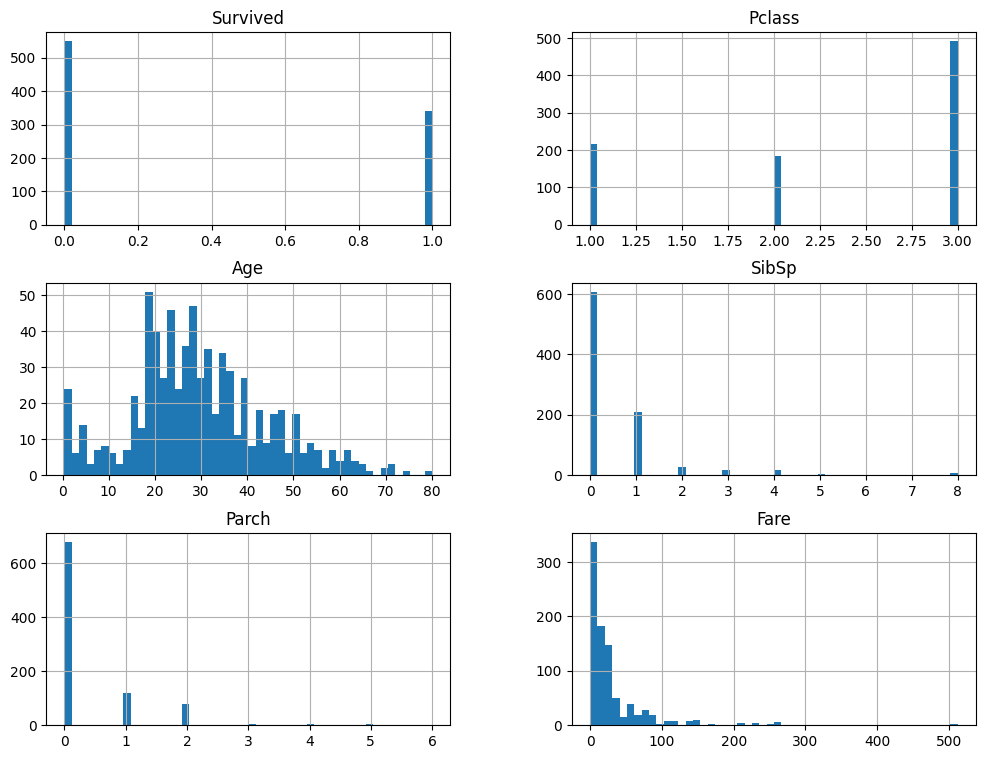

In [159]:
train_data.hist(bins=50, figsize=(12, 9))
plt.show()

## Start with Preprocessing Pipeline

In [160]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

#### Start with numerical pipeline

In [161]:
num_pipeline = Pipeline([
  ("imputer", SimpleImputer(strategy="median")),
  ("scaler", StandardScaler())
])

#### Continue with categorical pipeline

In [162]:
cat_pipeline = Pipeline([
  ("ordinal_encoder", OrdinalEncoder()),
  ("imputer", SimpleImputer(strategy="most_frequent")),
  ("cat_encoder", OneHotEncoder(sparse_output=False))
])

#### Combine both pipelines

In [163]:
num_attributes = ["Pclass",	"Age", "SibSp",	"Parch"]
cat_attributes = ["Sex", "Embarked"]

preprocess_pipeline = ColumnTransformer([
  ("num", num_pipeline, num_attributes),
  ("cat", cat_pipeline, cat_attributes)
])

## Get X_train and y_train

In [164]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[ 0.82737724, -0.56573582,  0.43279337, ...,  0.        ,
         0.        ,  1.        ],
       [-1.56610693,  0.6638609 ,  0.43279337, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.82737724, -0.25833664, -0.4745452 , ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.82737724, -0.10463705,  0.43279337, ...,  0.        ,
         0.        ,  1.        ],
       [-1.56610693, -0.25833664, -0.4745452 , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.82737724,  0.20276213, -0.4745452 , ...,  0.        ,
         1.        ,  0.        ]])

In [165]:
y_train = train_data["Survived"]

## Try out different models

In [171]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.metrics import make_scorer, roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

X_test = preprocess_pipeline.fit_transform(test_data)

#### RandomForestClassifier

In [169]:
tree_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)

tree_clf.fit(X_train, y_train)
cross_val_score(tree_clf, X_train, y_train, cv=10).mean()

0.8238077403245943

Try to get better prediction with RandomizedSearchCV

In [194]:
param_distribs_rfc = {"max_leaf_nodes": randint(2, 20),
                  "max_depth": randint(2, 20)}

rand_search_rfc = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_distribs_rfc,
                                 n_iter=40, n_jobs=-1, cv=3, scoring="f1_weighted", random_state=42)

rand_search_rfc.fit(X_train, y_train)
rand_search_rfc.best_params_

{'max_depth': 15, 'max_leaf_nodes': 19}

In [195]:
tree_clf_hypertuned = RandomForestClassifier(n_estimators=500, max_leaf_nodes=19, max_depth=15, random_state=42)

tree_clf_hypertuned.fit(X_train, y_train)
cross_val_score(tree_clf_hypertuned, X_train, y_train, cv=10).mean()

0.8283021223470662

### SVC

In [ ]:
svc_clf = SVC(kernel="rbf", gamma="auto", C=2)
svc_clf.fit(X_train, y_train)
cross_val_score(svc_clf, X_train, y_train).mean()

0.827154604230745

In [203]:
param_distribs_svc = {"C": uniform(2, 20),
                  "gamma": uniform(0.1, 1)}

rand_search_svc = RandomizedSearchCV(SVC(), param_distributions=param_distribs_svc,
                                 n_iter=40, n_jobs=-1, cv=3, scoring="f1_weighted", random_state=42)

rand_search_svc.fit(X_train, y_train)
rand_search_svc.best_params_

{'C': 8.092275383467413, 'gamma': 0.19767211400638388}

In [204]:
svc_clf_hypertuned = SVC(kernel="rbf", gamma=0.198, C=8.092)
svc_clf_hypertuned.fit(X_train, y_train)

cross_val_score(svc_clf_hypertuned, X_train, y_train).mean()

0.8103320569957944

#### KNeighborsClassifier

In [178]:
k_nearest_clf = KNeighborsClassifier()
k_nearest_clf.fit(X_train, y_train)
cross_val_score(k_nearest_clf, X_train, y_train).mean()

0.8024668884564685

In [216]:
param_distribs_knc = {"n_neighbors": randint(2, 20),
                  "p": randint(1, 10),
                  "leaf_size": randint(10, 50)}

param_distribs_knc = RandomizedSearchCV(KNeighborsClassifier(), param_distributions=param_distribs_knc,
                                 n_iter=40, n_jobs=-1, cv=3, scoring="f1_weighted", random_state=42)

param_distribs_knc.fit(X_train, y_train)
param_distribs_knc.best_params_

{'leaf_size': 38, 'n_neighbors': 19, 'p': 2}

In [217]:
k_nearest_clf_hypertuned = KNeighborsClassifier(p=2, n_neighbors=19, leaf_size=38)
k_nearest_clf_hypertuned.fit(X_train, y_train)
cross_val_score(k_nearest_clf_hypertuned, X_train, y_train).mean()

0.819327098110602

#### Ensemble Methods

In [219]:
voting_clf = VotingClassifier([
  ("rf", tree_clf_hypertuned),
  ("svc", svc_clf),
  ("kNear", k_nearest_clf_hypertuned)
])

In [220]:
voting_clf.fit(X_train, y_train)

for name, clf in voting_clf.named_estimators_.items():
  print(f"{name} = {cross_val_score(clf, X_train, y_train).mean()}")

rf = 0.8249074132195091
svc = 0.827154604230745
kNear = 0.819327098110602


In [221]:
cross_val_score(voting_clf, X_train, y_train).mean()

0.8237900947837549

## Write Predictions into a File

In [222]:
predictionSurvived = voting_clf.predict(X_test)
test_data["Survived"] = predictionSurvived
test_data = test_data[["Survived"]]
test_data.to_csv("Prediction.csv", index=True, header=True)
